In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats
import os, time, h5py, sys, glob, pickle, random, configparser
from tqdm import tqdm
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting, surface
import seaborn as sns
from itertools import combinations, product

In [2]:
sub_list = range(1,9)
exp_config = configparser.ConfigParser()
exp_config.read('../config')
# Set the directories
NSD_top_dir = exp_config['DIR']['NSD_top_dir']
output_fig_dir = os.path.join(NSD_top_dir, 'figures', 'Manuscript')

In [3]:
pred_results_dir = os.path.join(NSD_top_dir, 'results', 'CV_results_CLIP')

In [4]:
img_list_dir = os.path.join(NSD_top_dir, 'intermediate', 'features')
betas_dir = os.path.join(NSD_top_dir, 
                         'intermediate',
                         'betas_native')
roi_list = ['lPFC', 'Visual']

In [5]:
# First figure out what vertices to consider in RSA
# Load lPFC results
count = 0
for curr_roi in roi_list:
    for curr_sub in sub_list:
        if curr_roi == 'lPFC':
            curr_sub_df_dir = os.path.join(pred_results_dir, 'sub0{}_img_GS_norm.csv'.format(curr_sub))
        elif curr_roi == 'Visual':
            curr_sub_df_dir = os.path.join(pred_results_dir, 'sub0{}_img_vvs_GS_norm.csv'.format(curr_sub))

        curr_sub_df = pd.read_csv(curr_sub_df_dir, header=None, names=['SUB', 'VERTEX', 'CV-r', 'best alpha']).drop_duplicates(subset=['SUB', 'VERTEX'])
        curr_sub_df['ROI'] = curr_roi
        if count == 0:
            count += 1
            summary_df = curr_sub_df
        else:
            summary_df = pd.concat([summary_df, curr_sub_df]).reset_index(drop=True)

In [6]:
filtered_summary_df = summary_df[summary_df['CV-r']>0.1]

In [7]:
# Find the shared images that appear in all subjects 
for curr_sub in sub_list:
    curr_sub_shared_img_list = np.load(os.path.join(img_list_dir,
                          'sub0{}_share_img_order.npy'.format(curr_sub)))
    if curr_sub == 1:
        shared_img_df = pd.DataFrame(curr_sub_shared_img_list, columns=['img_ind'])
        shared_img_df['SUB'] = curr_sub
    else:
        _img_df = pd.DataFrame(curr_sub_shared_img_list, columns=['img_ind'])
        _img_df['SUB'] = curr_sub
        shared_img_df = shared_img_df.append(_img_df).reset_index(drop=True)

In [8]:
# Only include images with all three valid presentations for this analysis
for curr_sub in tqdm(sub_list):
        
    # Load the share image list
    share_img_list = np.load(os.path.join(img_list_dir, 'sub0{}_share_img_order.npy'.format(curr_sub)))

    _bulk_size = 100
    _num_bulks = int(np.ceil(len(share_img_list)/_bulk_size))
    img_count = []
    for curr_bulk in range(_num_bulks):
        _start_ind = curr_bulk*_bulk_size
        _end_ind = (curr_bulk+1)*_bulk_size
        curr_bulk_dir = os.path.join(betas_dir,
                                    'sub0{}_betas_{}to{}_share_norm'.format(curr_sub,
                                                   _start_ind,
                                                    _end_ind))
        with open(curr_bulk_dir, "rb") as f:
            curr_beta = pickle.load(f)
        curr_bulk_count = [k.shape[1] for k in curr_beta]
        img_count = img_count + curr_bulk_count

    curr_sub_count = pd.DataFrame(img_count, columns=['count'])
    curr_sub_count['img_ind'] = share_img_list
    curr_sub_count['SUB'] = curr_sub
    if curr_sub == 1:
        all_sub_count = curr_sub_count
    else:
        all_sub_count = all_sub_count.append(curr_sub_count).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.40s/it]


In [9]:
all_sub_count_rep = all_sub_count[all_sub_count['count'] == 3]
rep_img_count = all_sub_count_rep.groupby(by='img_ind').count().reset_index()
filtered_img_count = rep_img_count[rep_img_count['SUB'] == 8]['img_ind'].values

In [10]:
similarity_dict = {}
bool_mat = np.ones((len(filtered_img_count),
                   len(filtered_img_count)), dtype=bool)
triu_mat = np.triu(bool_mat, k=1)
for curr_roi in roi_list:
    for curr_sub in tqdm(sub_list):

        # Load the share image list
        share_img_list = np.load(os.path.join(img_list_dir, 'sub0{}_share_img_order.npy'.format(curr_sub)))
        assert np.all(share_img_list[np.isin(share_img_list, filtered_img_count)] == filtered_img_count)

        # Load the betas
        final_selected_verts = list(filtered_summary_df[(filtered_summary_df['SUB']==curr_sub)&
                    (filtered_summary_df['ROI']==curr_roi)]['VERTEX'].values)

        _bulk_size = 100
        _num_bulks = int(np.ceil(len(share_img_list)/_bulk_size))
        for curr_bulk in range(_num_bulks):
            _start_ind = curr_bulk*_bulk_size
            _end_ind = (curr_bulk+1)*_bulk_size
            if curr_roi == 'lPFC':
                curr_bulk_dir = os.path.join(betas_dir,
                                            'sub0{}_betas_{}to{}_share_norm'.format(curr_sub,
                                                           _start_ind,
                                                            _end_ind))
            elif curr_roi == 'Visual':
                curr_bulk_dir = os.path.join(betas_dir,
                                            'sub0{}_betas_{}to{}_vvs_share_norm'.format(curr_sub,
                                                           _start_ind,
                                                            _end_ind,
                                                            ))
                
            with open(curr_bulk_dir, "rb") as f:
                curr_beta = pickle.load(f)
            sampled_vert = np.array([np.mean(k[final_selected_verts, :], axis=1) for k in curr_beta])

            if curr_bulk == 0:
                betas_array_share = sampled_vert
            else:
                betas_array_share = np.vstack((betas_array_share, sampled_vert))
            #list_betas_unique = list_betas_unique + sampled_vert

        # included images
        # Make sure that the image order is exactly the same across people
        included_indices = np.zeros((len(filtered_img_count), 1)).astype(int)
        for ind, curr_img in enumerate(filtered_img_count):
            included_indices[ind] = np.where(share_img_list==curr_img)[0][0]
        included_images_betas = betas_array_share[included_indices.squeeze(), :]

        # Get a similarity matrix
        similarity_mat = euclidean_distances(included_images_betas, included_images_betas)


        similarity_dict['sub{}_{}'.format(curr_sub,
                                          curr_roi)] = similarity_mat[triu_mat]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.66s/it]


In [11]:
# Across subject
sim_df = pd.DataFrame(columns=['SUB_A', 'SUB_B', 'ROI_A', 'ROI_B', 'type', 'sim'])

for curr_sub_comb in combinations(sub_list, 2):
    for curr_roi in roi_list:
    
        sim_repA = similarity_dict['sub{}_{}'.format(curr_sub_comb[0],
                                      curr_roi)]
        sim_repB = similarity_dict['sub{}_{}'.format(curr_sub_comb[1],
                                      curr_roi)]
        
        # Need to get rid of the zeros
        selected_sim_repA = sim_repA[(sim_repA!=0)&(sim_repB!=0)]
        selected_sim_repB = sim_repB[(sim_repA!=0)&(sim_repB!=0)]
        
        curr_corr, _ = stats.spearmanr(selected_sim_repA, selected_sim_repB)

        curr_corr, _ = stats.spearmanr(sim_repA, sim_repB)
        sim_df.loc[len(sim_df)] = {'SUB_A': curr_sub_comb[0], 
                                   'SUB_B': curr_sub_comb[1], 
                                   'ROI_A': curr_roi, 
                                   'ROI_B': curr_roi, 
                                   'type':'across-subject, {}'.format(curr_roi),
                                   'sim': curr_corr}

In [12]:
sim_df['SUB Comb'] = sim_df['SUB_A'].apply(str) + '-' + sim_df['SUB_B'].apply(str)
sim_df['ROI_comb'] = sim_df['ROI_A'].apply(str) + '-' + sim_df['ROI_B'].apply(str)


In [13]:
sim_df_lPFC = sim_df[sim_df['ROI_A']=='lPFC']

In [14]:
sim_df_visual = sim_df[sim_df['ROI_A']=='Visual']

In [15]:
merge_df = sim_df_lPFC.merge(sim_df_visual, on = ['SUB Comb'])

In [16]:
print('Visual: mean = {}, sd = {}'.format(str(sim_df_visual['sim'].mean().round(2)),
                                        str(sim_df_visual['sim'].std().round(2))))

Visual: mean = 0.33, sd = 0.08


In [17]:
print('lPFC: mean = {}, sd = {}'.format(str(sim_df_lPFC['sim'].mean().round(2)),
                                        str(sim_df_lPFC['sim'].std().round(2))))

lPFC: mean = 0.11, sd = 0.04


In [18]:
stats.wilcoxon(merge_df['sim_x'], merge_df['sim_y'])

WilcoxonResult(statistic=0.0, pvalue=3.789619441580871e-06)

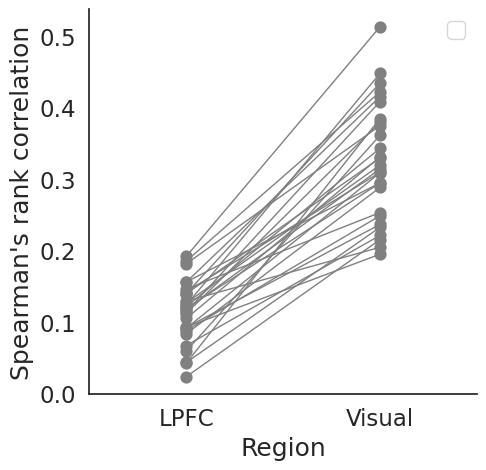

In [19]:
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.set_style('white')


ax = sns.pointplot(x='type', y='sim', hue='SUB Comb', palette=['grey']*56,
                   data=sim_df[sim_df['type']!='within-subject, \n across region'])
plt.legend([])
#ax.axhline(y=0, ls='--')
ax.set_ylabel("Spearman's rank correlation")
ax.set_xticklabels(['LPFC', 'Visual'])
ax.set_xlabel('Region')
sns.despine(top=True, right=True)
lw = ax.lines[0].get_linewidth() # lw of first line
plt.setp(ax.lines,linewidth=1)
plt.savefig(os.path.join(output_fig_dir, 'RSA_square.pdf'), dpi=50)

In [24]:
# Within subject
sim_df = pd.DataFrame(columns=['SUB', 'ROI_A', 'ROI_B', 'type', 'sim'])

for curr_sub in sub_list:
    
    sim_repA = similarity_dict['sub{}_{}'.format(curr_sub, roi_list[0])]
    sim_repB = similarity_dict['sub{}_{}'.format(curr_sub, roi_list[1])]

    # Need to get rid of the zeros
    selected_sim_repA = sim_repA[(sim_repA!=0)&(sim_repB!=0)]
    selected_sim_repB = sim_repB[(sim_repA!=0)&(sim_repB!=0)]

    curr_corr, _ = stats.spearmanr(selected_sim_repA, selected_sim_repB)

    curr_corr, _ = stats.spearmanr(sim_repA, sim_repB)
    sim_df.loc[len(sim_df)] = {'SUB': curr_sub,
                               'ROI_A': roi_list[0], 
                               'ROI_B': roi_list[1], 
                               'type':'within-subject',
                               'sim': curr_corr}

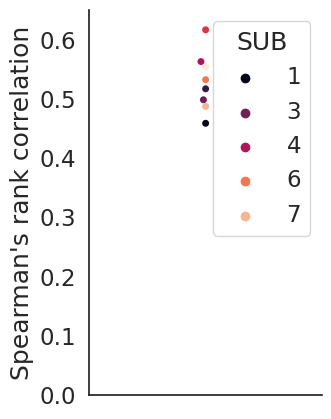

In [28]:
plt.figure(figsize=(3,5))
sns.set(font_scale=1.5)
sns.set_style('white')
ax = sns.swarmplot(y='sim', hue='SUB', palette='rocket', 
                   data=sim_df)
ax.set_ylabel("Spearman's rank correlation")
sns.despine(top=True, right=True)
plt.ylim([0, 0.65])
plt.savefig(os.path.join(output_fig_dir, 'RSA_within_square.pdf'), dpi=50)

# Auditory cortex

In [26]:
img_list_dir = os.path.join(NSD_top_dir, 'intermediate', 'features')
betas_dir = os.path.join(NSD_top_dir, 
                         'intermediate',
                         'betas_native')
roi_list = ['lPFC', 'Visual', 'A1']

In [27]:
# First figure out what vertices to consider in RSA
# Load lPFC results
count = 0
for curr_roi in roi_list:
    for curr_sub in sub_list:
        if curr_roi == 'lPFC':
            curr_sub_df_dir = os.path.join(pred_results_dir, 'sub0{}_img_GS_norm.csv'.format(curr_sub))
        elif curr_roi == 'Visual':
            curr_sub_df_dir = os.path.join(pred_results_dir, 'sub0{}_img_vvs_GS_norm.csv'.format(curr_sub))
        elif curr_roi == 'A1':
            curr_sub_df_dir = os.path.join(pred_results_dir, 'sub0{}_img_A1_GS_norm.csv'.format(curr_sub))

        curr_sub_df = pd.read_csv(curr_sub_df_dir, header=None, names=['SUB', 'VERTEX', 'CV-r', 'best alpha'])
        curr_sub_df['ROI'] = curr_roi
        if count == 0:
            count += 1
            summary_df = curr_sub_df
        else:
            summary_df = pd.concat([summary_df, curr_sub_df]).reset_index(drop=True)

In [28]:
filtered_summary_df = summary_df[summary_df['CV-r']>0.1]
# Find the shared images that appear in all subjects 
for curr_sub in sub_list:
    curr_sub_shared_img_list = np.load(os.path.join(img_list_dir,
                          'sub0{}_share_img_order.npy'.format(curr_sub)))
    if curr_sub == 1:
        shared_img_df = pd.DataFrame(curr_sub_shared_img_list, columns=['img_ind'])
        shared_img_df['SUB'] = curr_sub
    else:
        _img_df = pd.DataFrame(curr_sub_shared_img_list, columns=['img_ind'])
        _img_df['SUB'] = curr_sub
        shared_img_df = shared_img_df.append(_img_df).reset_index(drop=True)
# Only include images with all three valid presentations for this analysis
for curr_sub in tqdm(sub_list):
        
    # Load the share image list
    share_img_list = np.load(os.path.join(img_list_dir, 'sub0{}_share_img_order.npy'.format(curr_sub)))

    _bulk_size = 100
    _num_bulks = int(np.ceil(len(share_img_list)/_bulk_size))
    img_count = []
    for curr_bulk in range(_num_bulks):
        _start_ind = curr_bulk*_bulk_size
        _end_ind = (curr_bulk+1)*_bulk_size
        curr_bulk_dir = os.path.join(betas_dir,
                                    'sub0{}_betas_{}to{}_share_norm'.format(curr_sub,
                                                   _start_ind,
                                                    _end_ind))
        with open(curr_bulk_dir, "rb") as f:
            curr_beta = pickle.load(f)
        curr_bulk_count = [k.shape[1] for k in curr_beta]
        img_count = img_count + curr_bulk_count

    curr_sub_count = pd.DataFrame(img_count, columns=['count'])
    curr_sub_count['img_ind'] = share_img_list
    curr_sub_count['SUB'] = curr_sub
    if curr_sub == 1:
        all_sub_count = curr_sub_count
    else:
        all_sub_count = all_sub_count.append(curr_sub_count).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


In [29]:
all_sub_count_rep = all_sub_count[all_sub_count['count'] == 3]
rep_img_count = all_sub_count_rep.groupby(by='img_ind').count().reset_index()
filtered_img_count = rep_img_count[rep_img_count['SUB'] == 8]['img_ind'].values

In [30]:
similarity_dict = {}
bool_mat = np.ones((len(filtered_img_count),
                   len(filtered_img_count)), dtype=bool)
triu_mat = np.triu(bool_mat, k=1)
for curr_roi in roi_list:
    for curr_sub in tqdm(sub_list):

        # Load the share image list
        share_img_list = np.load(os.path.join(img_list_dir, 'sub0{}_share_img_order.npy'.format(curr_sub)))
        assert np.all(share_img_list[np.isin(share_img_list, filtered_img_count)] == filtered_img_count)

        # Load the betas
        final_selected_verts = list(filtered_summary_df[(filtered_summary_df['SUB']==curr_sub)&
                    (filtered_summary_df['ROI']==curr_roi)]['VERTEX'].values)

        _bulk_size = 100
        _num_bulks = int(np.ceil(len(share_img_list)/_bulk_size))
        for curr_bulk in range(_num_bulks):
            _start_ind = curr_bulk*_bulk_size
            _end_ind = (curr_bulk+1)*_bulk_size
            if curr_roi == 'lPFC':
                curr_bulk_dir = os.path.join(betas_dir,
                                            'sub0{}_betas_{}to{}_share_norm'.format(curr_sub,
                                                           _start_ind,
                                                            _end_ind))
            elif curr_roi == 'Visual':
                curr_bulk_dir = os.path.join(betas_dir,
                                            'sub0{}_betas_{}to{}_vvs_share_norm'.format(curr_sub,
                                                           _start_ind,
                                                            _end_ind,
                                                            ))
            elif curr_roi == 'A1':
                curr_bulk_dir = os.path.join(betas_dir,
                                            'sub0{}_betas_{}to{}_A1_share_norm'.format(curr_sub,
                                                           _start_ind,
                                                            _end_ind,
                                                            ))
                
            with open(curr_bulk_dir, "rb") as f:
                curr_beta = pickle.load(f)
            sampled_vert = np.array([np.mean(k[final_selected_verts, :], axis=1) for k in curr_beta])

            if curr_bulk == 0:
                betas_array_share = sampled_vert
            else:
                betas_array_share = np.vstack((betas_array_share, sampled_vert))
            #list_betas_unique = list_betas_unique + sampled_vert

        # included images
        # Make sure that the image order is exactly the same across people
        included_indices = np.zeros((len(filtered_img_count), 1)).astype(int)
        for ind, curr_img in enumerate(filtered_img_count):
            included_indices[ind] = np.where(share_img_list==curr_img)[0][0]
        included_images_betas = betas_array_share[included_indices.squeeze(), :]

        # Get a similarity matrix
        similarity_mat = euclidean_distances(included_images_betas, included_images_betas)


        similarity_dict['sub{}_{}'.format(curr_sub,
                                          curr_roi)] = similarity_mat[triu_mat]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.08it/s]


In [31]:
# Within subject
sim_df = pd.DataFrame(columns=['SUB', 'ROI_A', 'ROI_B', 'type', 'sim'])

for curr_sub in sub_list:
    for curr_roi_comb in combinations(roi_list, 2):
        sim_repA = similarity_dict['sub{}_{}'.format(curr_sub, curr_roi_comb[0])]
        sim_repB = similarity_dict['sub{}_{}'.format(curr_sub, curr_roi_comb[1])]

        # Need to get rid of the zeros
        selected_sim_repA = sim_repA[(sim_repA!=0)&(sim_repB!=0)]
        selected_sim_repB = sim_repB[(sim_repA!=0)&(sim_repB!=0)]

        curr_corr, _ = stats.spearmanr(selected_sim_repA, selected_sim_repB)

        curr_corr, _ = stats.spearmanr(sim_repA, sim_repB)
        sim_df.loc[len(sim_df)] = {'SUB': curr_sub,
                                   'ROI_A': curr_roi_comb[0], 
                                   'ROI_B': curr_roi_comb[1], 
                                   'type':'{}-{}'.format(curr_roi_comb[0], curr_roi_comb[1]),
                                   'sim': curr_corr}

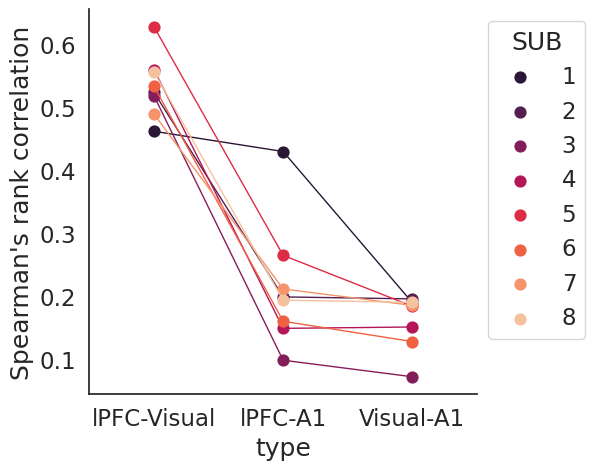

In [32]:
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.set_style('white')
ax = sns.pointplot(x='type',y='sim', hue='SUB', palette='rocket', 
                   data=sim_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_ylabel("Spearman's rank correlation")
sns.despine(top=True, right=True)
#plt.ylim([0, 0.65])
lw = ax.lines[0].get_linewidth() # lw of first line
plt.setp(ax.lines,linewidth=1)
plt.savefig(os.path.join(output_fig_dir, 'RSA_within_square.pdf'), dpi=50)

In [33]:
# Run some stats
df_lPFC_vvs = sim_df[sim_df['type']=='lPFC-Visual'].sort_values(by='SUB')
df_lPFC_A1 = sim_df[sim_df['type']=='lPFC-A1'].sort_values(by='SUB')
df_A1_vvs = sim_df[sim_df['type']=='Visual-A1'].sort_values(by='SUB')

In [34]:
stats.wilcoxon(df_lPFC_vvs['sim'], df_lPFC_A1['sim'])

WilcoxonResult(statistic=0.0, pvalue=0.0078125)

In [35]:
stats.wilcoxon(df_lPFC_vvs['sim'], df_A1_vvs['sim'])

WilcoxonResult(statistic=0.0, pvalue=0.0078125)